In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd 'drive/My Drive/Siamese/Identification'

/content/drive/My Drive/Siamese/Identification


In [3]:
import sys
sys.path.insert(0, '..')
sys.path.insert(0, '../Data')
sys.path.insert(0, '../Encoder')

In [4]:
!pip install torchaudio

In [5]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Compose

from tqdm import tqdm

In [6]:
DATASET_PATH = '/content/drive/My Drive/DataSet'
MODEL_PATH = '/content/drive/My Drive/Siamese/net.nn'
EPOCH_NUM = 6

torch.backends.cudnn.deterministic = True

NUM_WORKERS = 4

In [7]:
from IdentificationDataset import IdentificationDataset
from IdentificationDataset import ReturnType

from Normalize import Normalize
from ToTensor import ToTensor

DATASET_PATH = '/content/drive/My Drive/DataSet'

transforms = Compose([
    Normalize(),
    ToTensor()
])

testset = IdentificationDataset(DATASET_PATH, 
                                40,
                                train=False, 
                                transform=transforms,
                                lenght=3,
                                return_type=ReturnType.STANDARD)
testsetloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=1, 
                                            num_workers=NUM_WORKERS)

print("lenght test loader ", len(testsetloader))


sample lenght  3
lenght test loader  4874


In [8]:
from Conference import Conference

# Define default device, we should use the GPU (cuda) if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = Conference(DEVICE, time=False)

net.load_encoder(size=3)
net.to(DEVICE)

Encoder loaded


Conference(
  (encoder): TransFourier(
    (spectrogram): Spectrogram()
    (amp): AmplitudeToDB()
    (block1): Conv2DBlock(
      (conv1): Conv2d(1, 32, kernel_size=(1, 1), stride=(2, 1))
      (conv2): Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 1), padding=(3, 3))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (maxpool): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    )
    (block2): Conv2DBlock(
      (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(2, 1))
      (conv2): Conv2d(128, 192, kernel_size=(5, 5), stride=(2, 1), padding=(2, 2))
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (maxpool): MaxPool2d(kernel_size=(4, 2), stride=(4, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (block3): Conv2DBlock(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(2, 1))
      (conv2): Co

In [9]:
with torch.no_grad():
  # test
  net.eval()
  # Store the places
  speakers_list = testset.get_speakers_list(20)
  net.initspeakers(speakers_list)  
  net.initplaces(speakers_list, maxsize=3)

In [10]:
import numpy as np

dict_error = {}
dict_nb = {}

with torch.no_grad():
  best_accuracy = 0
  mean_accuracies = []
  topk_accuracies = []
  min_accuracies = []

  for epoch_num in range(EPOCH_NUM):
    print("*** Epoch ", epoch_num, " ***")
    mean_accuracy = 0
    topk_accuracy = 0
    min_accuracy = 0
    nb_test = 0

    for speaker in speakers_list:
      id = speaker[0]
      dict_error[id] = 0
      dict_nb[id] = 0

    for iter_num, (gold_label, sample) in tqdm(enumerate(testsetloader)):
      gold_label = gold_label.item()
      mean_label, topk_label, min_label = net(sample, gold_label)
      nb_test += 1
      dict_nb[gold_label] += 1

      if gold_label == mean_label:
        mean_accuracy += 1
      if gold_label == topk_label:
        topk_accuracy += 1
      else:
        dict_error[gold_label] += 1
      if gold_label == min_label:
        min_accuracy += 1

    mean_accuracy /= nb_test
    topk_accuracy /= nb_test
    min_accuracy /= nb_test
    mean_accuracies.append(mean_accuracy)
    topk_accuracies.append(topk_accuracy)
    min_accuracies.append(min_accuracy)
    print("accuracy mean ", mean_accuracy, "topk", topk_accuracy, 
          " min ", min_accuracy)
    add = 0
    nb = 0
    for id in dict_error:
      add += dict_error[id]
      nb += dict_nb[id]
      dict_error[id] =  100 * dict_error[id]//dict_nb[id] 
    print("Error ", add/nb)
    print(dict_error)

  net.store_speakers(20, 3)

*** Epoch  0  ***


4874it [02:12, 36.79it/s]

accuracy mean  0.38695116947066066 topk 0.6754205990972507  min  0.6731637258924907
Error  0.3245794009027493
{270: 6, 272: 38, 273: 29, 274: 37, 275: 21, 276: 51, 277: 68, 278: 4, 271: 71, 279: 57, 280: 52, 281: 27, 282: 20, 283: 42, 285: 54, 284: 10, 286: 43, 287: 41, 288: 56, 289: 25, 290: 25, 291: 50, 292: 21, 293: 26, 294: 48, 295: 32, 296: 33, 297: 84, 298: 8, 299: 16, 300: 13, 301: 37, 302: 68, 303: 11, 304: 50, 305: 45, 306: 16, 307: 11, 308: 50, 309: 21}
*** Epoch  1  ***



4874it [02:13, 36.43it/s]

accuracy mean  0.5800164136233074 topk 0.7429216249487074  min  0.7215839146491588
Error  0.25707837505129255
{270: 12, 272: 44, 273: 40, 274: 27, 275: 17, 276: 18, 277: 49, 278: 9, 271: 34, 279: 36, 280: 23, 281: 23, 282: 9, 283: 34, 285: 33, 284: 12, 286: 7, 287: 31, 288: 39, 289: 10, 290: 17, 291: 13, 292: 29, 293: 32, 294: 19, 295: 30, 296: 37, 297: 60, 298: 14, 299: 14, 300: 18, 301: 29, 302: 56, 303: 7, 304: 33, 305: 24, 306: 21, 307: 16, 308: 35, 309: 27}
*** Epoch  2  ***



4874it [02:14, 36.20it/s]

accuracy mean  0.6516208453016004 topk 0.7492819039803037  min  0.7230201066885515
Error  0.25071809601969636
{270: 16, 272: 26, 273: 47, 274: 27, 275: 16, 276: 17, 277: 34, 278: 9, 271: 28, 279: 22, 280: 20, 281: 26, 282: 10, 283: 38, 285: 35, 284: 11, 286: 10, 287: 27, 288: 22, 289: 6, 290: 18, 291: 13, 292: 33, 293: 34, 294: 18, 295: 30, 296: 38, 297: 45, 298: 14, 299: 14, 300: 19, 301: 27, 302: 48, 303: 5, 304: 32, 305: 25, 306: 20, 307: 16, 308: 21, 309: 26}
*** Epoch  3  ***



4874it [02:15, 36.05it/s]

accuracy mean  0.6581862946245384 topk 0.7379975379565039  min  0.7127615921214608
Error  0.2620024620434961
{270: 21, 272: 32, 273: 48, 274: 25, 275: 17, 276: 18, 277: 26, 278: 10, 271: 30, 279: 20, 280: 22, 281: 25, 282: 10, 283: 42, 285: 37, 284: 11, 286: 9, 287: 27, 288: 18, 289: 6, 290: 20, 291: 14, 292: 36, 293: 35, 294: 21, 295: 39, 296: 37, 297: 43, 298: 14, 299: 22, 300: 22, 301: 29, 302: 43, 303: 8, 304: 33, 305: 25, 306: 20, 307: 15, 308: 21, 309: 27}
*** Epoch  4  ***



4874it [02:16, 35.81it/s]


accuracy mean  0.6528518670496513 topk 0.7295855560114896  min  0.7053754616331556
Error  0.27041444398851044
{270: 20, 272: 32, 273: 51, 274: 25, 275: 20, 276: 18, 277: 25, 278: 10, 271: 27, 279: 25, 280: 22, 281: 33, 282: 9, 283: 44, 285: 37, 284: 11, 286: 11, 287: 27, 288: 18, 289: 6, 290: 20, 291: 14, 292: 36, 293: 36, 294: 22, 295: 42, 296: 44, 297: 41, 298: 16, 299: 22, 300: 22, 301: 29, 302: 41, 303: 8, 304: 34, 305: 26, 306: 23, 307: 17, 308: 21, 309: 26}
*** Epoch  5  ***


4874it [02:15, 35.94it/s]


accuracy mean  0.6508001641362331 topk 0.7293803857201477  min  0.7041444398851047
Error  0.27061961427985226
{270: 20, 272: 34, 273: 52, 274: 25, 275: 17, 276: 18, 277: 23, 278: 10, 271: 26, 279: 19, 280: 22, 281: 34, 282: 14, 283: 42, 285: 37, 284: 15, 286: 10, 287: 29, 288: 18, 289: 6, 290: 20, 291: 14, 292: 37, 293: 37, 294: 22, 295: 43, 296: 48, 297: 39, 298: 17, 299: 22, 300: 22, 301: 29, 302: 39, 303: 7, 304: 34, 305: 27, 306: 22, 307: 18, 308: 18, 309: 26}


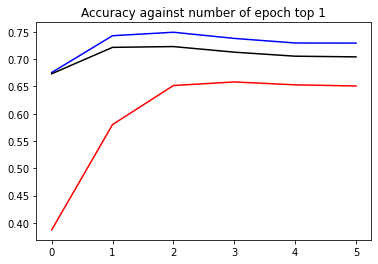

In [11]:
import matplotlib.pyplot as plt

plt.title("Accuracy against number of epoch top 1")
plt.plot([i for i in range(EPOCH_NUM)], mean_accuracies , label='test 1', color='red')
plt.plot([i for i in range(EPOCH_NUM)], topk_accuracies , label='test 1', color='blue')
plt.plot([i for i in range(EPOCH_NUM)], min_accuracies , label='test 1', color='black')


In [12]:
print("maximum of min", round(np.max(min_accuracies), 3))
print("maximum of topk", round(np.max(topk_accuracies), 3))
print("maximum of mean", round(np.max(mean_accuracies), 3))

maximum of min 0.723
maximum of topk 0.749
maximum of mean 0.658
